In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [24]:
df = pd.read_csv("/kaggle/input/bmidataset/bmi.csv")

In [25]:
df.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  500 non-null    object
 1   Height  500 non-null    int64 
 2   Weight  500 non-null    int64 
 3   Index   500 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Height,500.0,169.944,16.375261,140.0,156.0,170.5,184.0,199.0
Weight,500.0,106.000,32.382607,50.0,80.0,106.0,136.0,160.0
Index,500.0,3.748,1.355053,0.0,3.0,4.0,5.0,5.0


In [28]:
df.columns

Index(['Gender', 'Height', 'Weight', 'Index'], dtype='object')

In [29]:
df.isnull().sum()

Gender    0
Height    0
Weight    0
Index     0
dtype: int64

In [30]:
df.shape

(500, 4)

In [31]:
df.columns

Index(['Gender', 'Height', 'Weight', 'Index'], dtype='object')

<Axes: xlabel='Index', ylabel='count'>

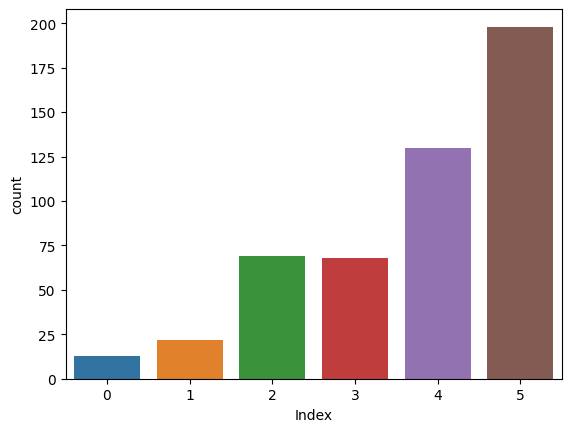

In [32]:
sns.countplot(x="Index", data=df)

In [33]:
df["Index"].value_counts()

Index
5    198
4    130
2     69
3     68
1     22
0     13
Name: count, dtype: int64

In [35]:
df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1})

In [36]:
df

,Gender,Height,Weight,Index
0,0,174,96,4
1,0,189,87,2
2,1,185,110,4
3,1,195,104,3
4,0,149,61,3
...,...,...,...,...
495,1,150,153,5
496,1,184,121,4
497,1,141,136,5
498,0,150,95,5


In [37]:
X = df.drop(["Index"], axis=1)
y = df["Index"]

In [38]:
X.head()

,Gender,Height,Weight
0,0,174,96
1,0,189,87
2,1,185,110
3,1,195,104
4,0,149,61


In [39]:
stdScaler = StandardScaler()
X[X.columns] = stdScaler.fit_transform(X)

In [40]:
X.head()

,Gender,Height,Weight
0,-1.020204,0.247939,-0.309117
1,-1.020204,1.164872,-0.587322
2,0.980196,0.920357,0.123647
3,0.980196,1.531645,-0.061823
4,-1.020204,-1.280283,-1.391027


In [42]:
# Apply SMOTE to oversample the minority class on the entire dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Now X_resampled and y_resampled contain the oversampled data

Index
4    198
2    198
3    198
5    198
1    198
0    198
Name: count, dtype: int64


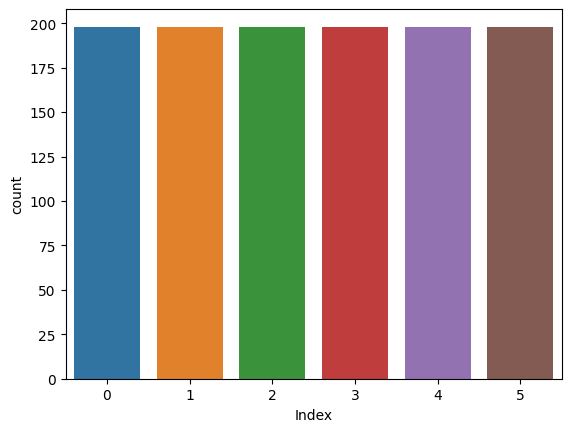

In [43]:
sns.countplot(x=y_resampled)
print(y_resampled.value_counts())

In [19]:
!pip install -U scikit-activeml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 59.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 39.6 MB/s eta 0:00:00:00:0100:01
  Created wheel for iteration-utilities: filename=iteration_utilities-0.11.0-cp310-cp310-linux_x86_64.whl size=103662 sha256=cf80937167708f1fa91b0f31cd3b5fe00a72aac2568325f62b98985df8cc40e6
  Stored in directory: /root/.cache/pip/wheels/2d/ab/c4/309aa5942beba1f36d6744acf619b7a314fca50f6a7ccce68c
Successfully built iteration-utilities
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Success

In [44]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import QueryByCommittee, RandomSampling, UncertaintySampling
from skactiveml.utils import MISSING_LABEL, labeled_indices, unlabeled_indices
from skactiveml.visualization import plot_decision_boundary, plot_utilities
from sklearn.datasets import load_digits, load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [45]:
def evaluate_active_learning(datasets):
    for dataset_name, (X, y_true) in datasets.items():
        print(f"Evaluating dataset: {dataset_name}")
        clf = SklearnClassifier(RandomForestClassifier(), classes=np.unique(y_true))
        methods = [
            "margin_sampling",
            "entropy",
            "least_confident",
            "random_sampling",
            "KL_divergence",
        ]
        n_cycles = 100
        accuracies = {method: [] for method in methods}

        for method in methods:
            if method in ["random_sampling"]:
                qs = RandomSampling(random_state=42)
            elif method in ["KL_divergence"]:
                qs = QueryByCommittee(random_state=42, method=method)
            else:
                qs = UncertaintySampling(method=method, random_state=42)

            y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
            clf.fit(X, y)
            for c in range(n_cycles):
                if method in ["random_sampling"]:
                    query_idx = qs.query(X=X, y=y, batch_size=1)
                elif method in ["KL_divergence"]:
                    query_idx = qs.query(X=X, y=y, ensemble=clf, batch_size=1)
                else:
                    query_idx = qs.query(X=X, y=y, clf=clf, batch_size=1)

                y[query_idx] = y_true[query_idx]
                clf.fit(X, y)

                accuracy = clf.score(X, y_true)
                accuracies[method].append(accuracy)

        # Print accuracies for each method
        print(f"Accuracies for dataset: {dataset_name}")
        for method, accuracy in accuracies.items():
            print(f"  Method: {method}, Accuracy: {accuracy[-1]:.4f}")

        # Plot accuracies
        plt.figure(figsize=(10, 6))
        max_accuracy = 0
        best_method = ""
        for method, accuracy in accuracies.items():
            plt.plot(range(1, n_cycles + 1), accuracy, label=method, marker="o")
            if accuracy[-1] > max_accuracy:
                max_accuracy = accuracy[-1]
                best_method = method

        plt.title(f"Accuracy vs Iterations - {dataset_name}")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print the method with the highest accuracy
        print(
            f"The method with the highest accuracy for dataset {dataset_name} is {best_method} with an accuracy of {max_accuracy:.4f}.\n"
        )

Evaluating dataset: unbalanced-data
Accuracies for dataset: unbalanced-data
  Method: margin_sampling, Accuracy: 0.8060
  Method: entropy, Accuracy: 0.7840
  Method: least_confident, Accuracy: 0.8040
  Method: random_sampling, Accuracy: 0.7700
  Method: KL_divergence, Accuracy: 0.7860


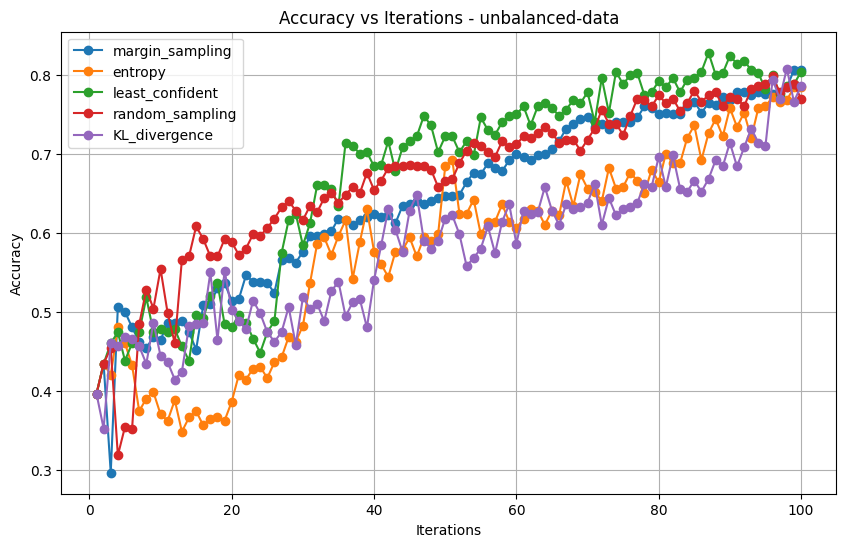

The method with the highest accuracy for dataset unbalanced-data is margin_sampling with an accuracy of 0.8060.

Evaluating dataset: imbalanced-data-after-balancing
Accuracies for dataset: imbalanced-data-after-balancing
  Method: margin_sampling, Accuracy: 0.6978
  Method: entropy, Accuracy: 0.8308
  Method: least_confident, Accuracy: 0.8165
  Method: random_sampling, Accuracy: 0.8241
  Method: KL_divergence, Accuracy: 0.7769


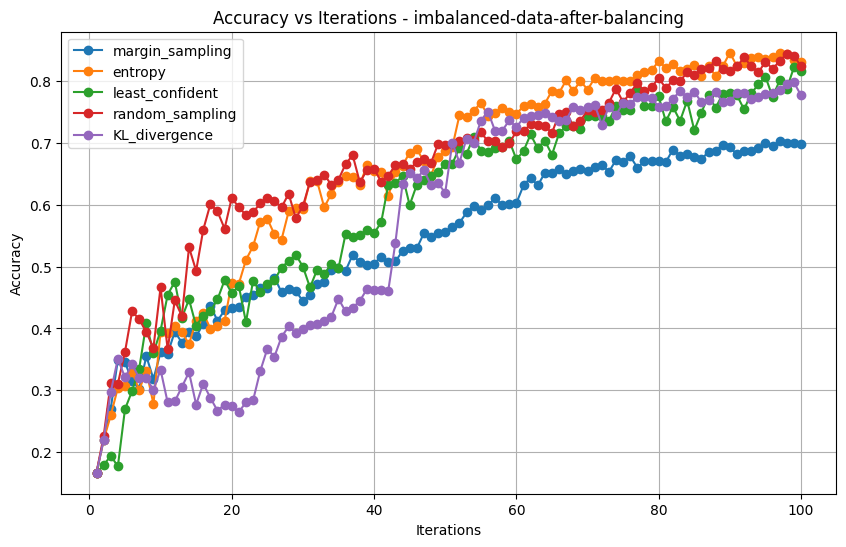

The method with the highest accuracy for dataset imbalanced-data-after-balancing is entropy with an accuracy of 0.8308.



In [48]:
# Define datasets"unbalanced-data":(X,y)"
datasets = {
    "unbalanced-data": (X, y),
    "imbalanced-data-after-balancing": (X_resampled, y_resampled),
}
# Call the function
evaluate_active_learning(datasets)